In [175]:
import numpy as np
import pandas as pd
import scanpy as sc
import re
import anndata as ad

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

sc.settings.verbosity = 2  # reduce the verbosity
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

import warnings
warnings.filterwarnings('ignore')

scanpy==1.9.5 anndata==0.9.2 umap==0.5.3 numpy==1.21.5 scipy==1.9.1 pandas==1.4.4 scikit-learn==1.0.2 statsmodels==0.13.2 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.10


# Functions

In [227]:
# Read and filter data (basic)
# Concatenate the two mixes (for G12C and G12D)
def read_data(condition, replicate_num = None, cache=True, unique=True, filter_mat=True, cells=3, genes=150):
    
    cond_to_path_dict = {'G12C': 'data/Mix/G12C/sample_filtered_feature_bc_matrix/',
                         'G12D': 'data/Mix/G12D/sample_filtered_feature_bc_matrix/',
                         'G12R': 'data/J951_G12R_mix_GEX/filtered_feature_bc_matrix'}
        
    if replicate_num is None:
        if condition == 'G12R':
            batch = condition
            adata = sc.read_10x_mtx(
                cond_to_path_dict[condition],
                var_names='gene_symbols',
                cache=cache)
                
            adata.obs.loc[:,'bitch'] = batch

        else:
            adata = None
            path = cond_to_path_dict[condition]
            for mix in [1,2]:
                for replicate in [1,2,3]:
                    batch = f'{condition}_{mix}_{replicate}'
                    p = re.sub('Mix', f'Mix{mix}', path)
                    p = re.sub(condition, f'{condition}_{replicate}', p)
                    print(f'Reading from {p}')
                    a = sc.read_10x_mtx(
                        p,
                        var_names='gene_symbols',
                        cache=cache)
                    a.obs.loc[:,'bitch'] = batch

                    if adata:
                        adata = adata.concatenate(a)
                    else:
                        adata = a
    else:
        path1 = re.sub('Mix', 'Mix1', cond_to_path_dict[condition])
        path1 = re.sub(condition, f'{condition}_{replicate_num}', path1)
        
        path2 = re.sub('Mix', 'Mix2', cond_to_path_dict[condition])
        path2 = re.sub(condition, f'{condition}_{replicate_num}', path2)
        
        adata1 = sc.read_10x_mtx(
            path1,
            var_names='gene_symbols',
            cache=cache)
        
        adata1.obs.loc[:,'bitch'] = f'{condition}_1_{replicate}'

        
        adata2 = sc.read_10x_mtx(
            path2,
            var_names='gene_symbols',
            cache=cache)
        
        adata1.obs.loc[:,'bitch'] = f'{condition}_2_{replicate}'

        adata = adata1.concatenate(adata2)
    
    if unique:
        adata.var_names_make_unique()
    
    print(adata)
    
    sc.pl.highest_expr_genes(adata, n_top=20)

    if filter_mat:
        sc.pp.filter_cells(adata, min_genes=genes)
        sc.pp.filter_genes(adata, min_cells=cells)
        
        print(f'\nAfter filter:\n\n{adata}')
        
    return adata


# filter mt genes and plot
def mt_initial_preprocess_and_plot(adata, var='mt', pattern='mt-', violin=True, scatter=True):
    adata.var[var] = adata.var_names.str.startswith(pattern)  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=[var], percent_top=None, log1p=False, inplace=True)
    
    if violin:
        sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
    
    if scatter:    
        sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
        sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
    
    print('mt_initial_preprocess_and_plot shape')
    display(adata)
    return adata


# filter, normalize, logarithmize and scale
def preprocess(adata, n_genes_by_counts=5e4, pct_counts_mt=20, normalize=True, target_sum=1e4, 
                         logarithmize=True, dynamic=True, min_mean=1, max_mean=6, min_disp=0.4):
    adata = adata[adata.obs.n_genes_by_counts < n_genes_by_counts, :]
    adata = adata[adata.obs.pct_counts_mt < pct_counts_mt, :]
    print('preprocess shape')
    display(adata)

    if normalize:
        sc.pp.normalize_total(adata, target_sum=target_sum)
        
    if logarithmize:
        sc.pp.log1p(adata)
    
    if dynamic:
        sc.pp.highly_variable_genes(adata, min_mean=min_mean, max_mean=max_mean, min_disp=min_disp)

    sc.pl.highly_variable_genes(adata)

    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]

    sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

    sc.pp.scale(adata, max_value=10)

    return adata


# neighborhood graph
def neighborhood_graph_and_clustering(adata, n_neighbors=10, n_pcs=40, plot=False, color=['Sgk3'], use_raw=False, perplexity=10): # remove `plot=False` if you want to see the coarse-grained graph
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca_variance_ratio(adata, log=True)

    sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)
    
    sc.tl.louvain(adata)
    sc.tl.leiden(adata)
    sc.tl.tsne(adata, perplexity=perplexity)
    sc.pl.tsne(adata, color=color, use_raw=use_raw)

    sc.tl.paga(adata)
    sc.pl.paga(adata, plot=plot)  
    sc.tl.umap(adata, init_pos='paga')    
    sc.pl.umap(adata, color=color, use_raw=use_raw)

    return adata


def markers(adata, clusters='leiden', method='wilcoxon', n_genes=25): # Other possibilities are 'logreg' and 't-test'
    sc.tl.rank_genes_groups(adata, clusters, method=method)
    sc.pl.rank_genes_groups(adata, n_genes=n_genes, sharey=False)
    
    top_genes_df = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

    return adata, top_genes_df

Running G12C
----------------------------------------------------------------------------

Reading from data/Mix1/G12C_1/sample_filtered_feature_bc_matrix/
... reading from cache file cache/data-Mix1-G12C_1-sample_filtered_feature_bc_matrix-matrix.h5ad
Reading from data/Mix1/G12C_2/sample_filtered_feature_bc_matrix/
... reading from cache file cache/data-Mix1-G12C_2-sample_filtered_feature_bc_matrix-matrix.h5ad
Reading from data/Mix1/G12C_3/sample_filtered_feature_bc_matrix/
... reading from cache file cache/data-Mix1-G12C_3-sample_filtered_feature_bc_matrix-matrix.h5ad
Reading from data/Mix2/G12C_1/sample_filtered_feature_bc_matrix/
... reading from cache file cache/data-Mix2-G12C_1-sample_filtered_feature_bc_matrix-matrix.h5ad
Reading from data/Mix2/G12C_2/sample_filtered_feature_bc_matrix/
... reading from cache file cache/data-Mix2-G12C_2-sample_filtered_feature_bc_matrix-matrix.h5ad
Reading from data/Mix2/G12C_3/sample_filtered_feature_bc_matrix/
... reading from cache file cache/

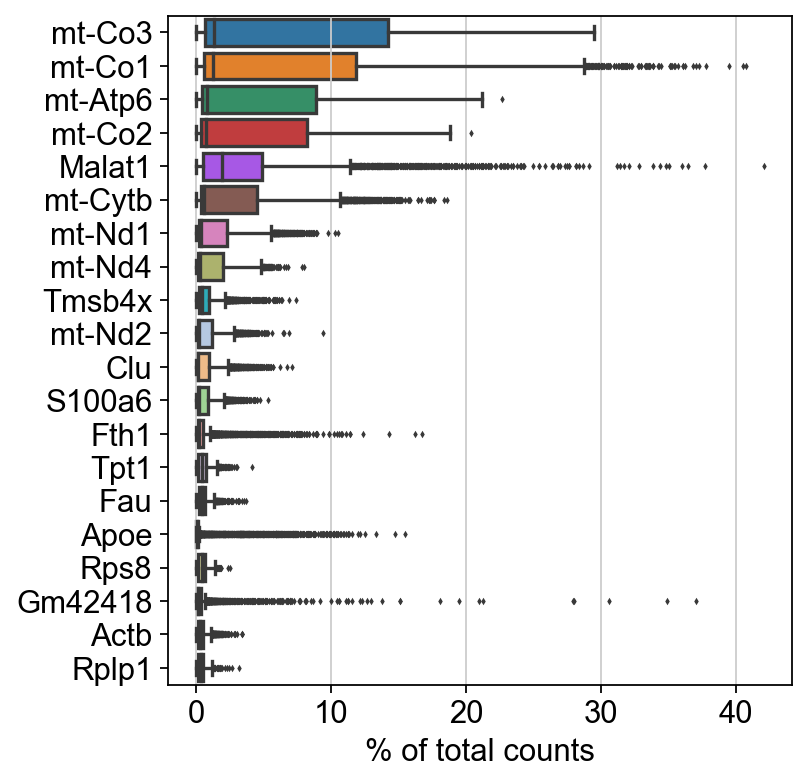

filtered out 881 cells that have less than 150 genes expressed
filtered out 12576 genes that are detected in less than 3 cells

After filter:

AnnData object with n_obs × n_vars = 8422 × 19709
    obs: 'bitch', 'batch', 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells'


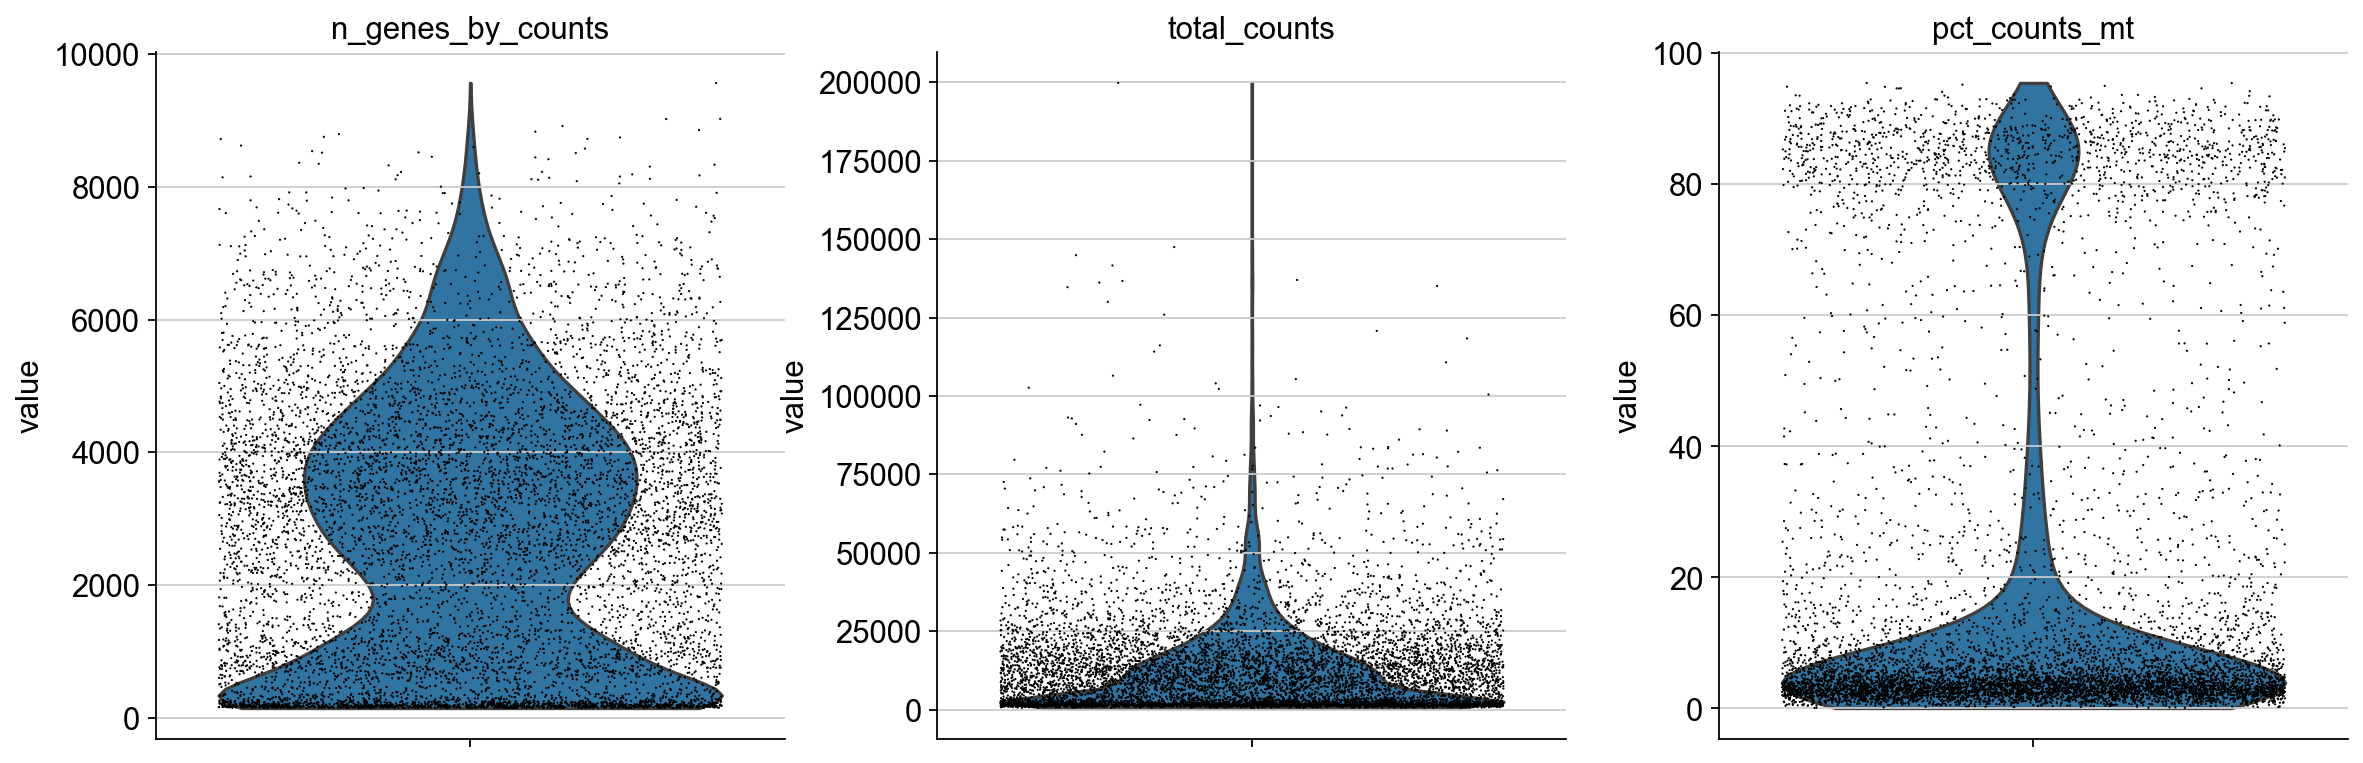

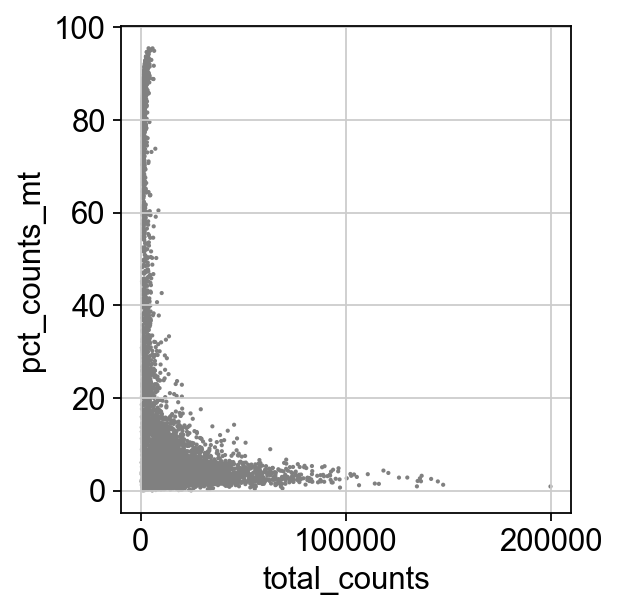

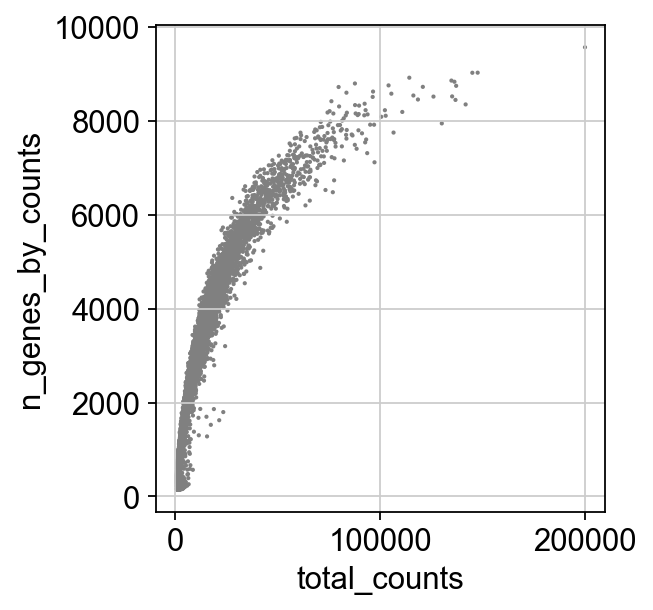

mt_initial_preprocess_and_plot shape


AnnData object with n_obs × n_vars = 8422 × 19709
    obs: 'bitch', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

preprocess shape


View of AnnData object with n_obs × n_vars = 6389 × 19709
    obs: 'bitch', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)


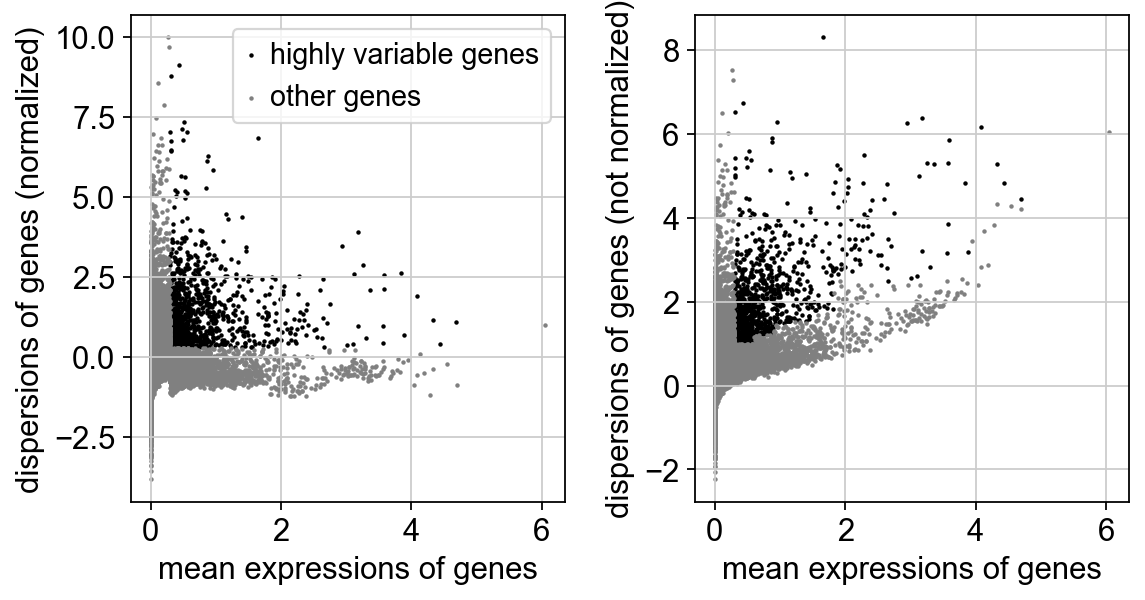

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:05)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


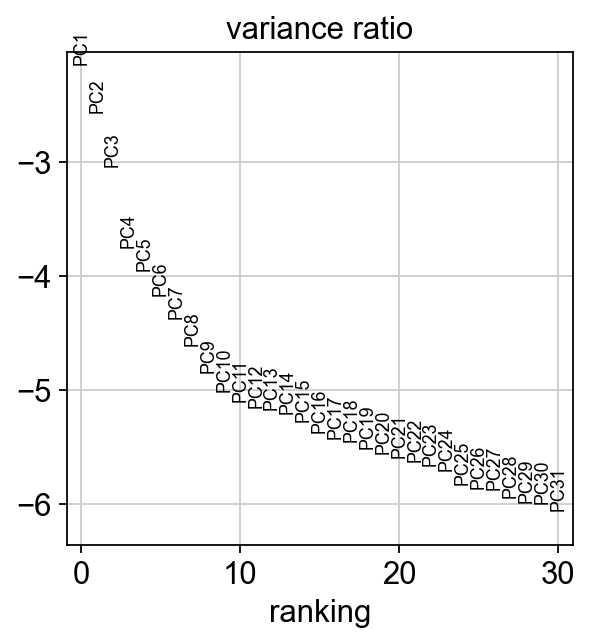

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)
running Leiden clustering
    finished (0:00:01)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished (0:00:21)


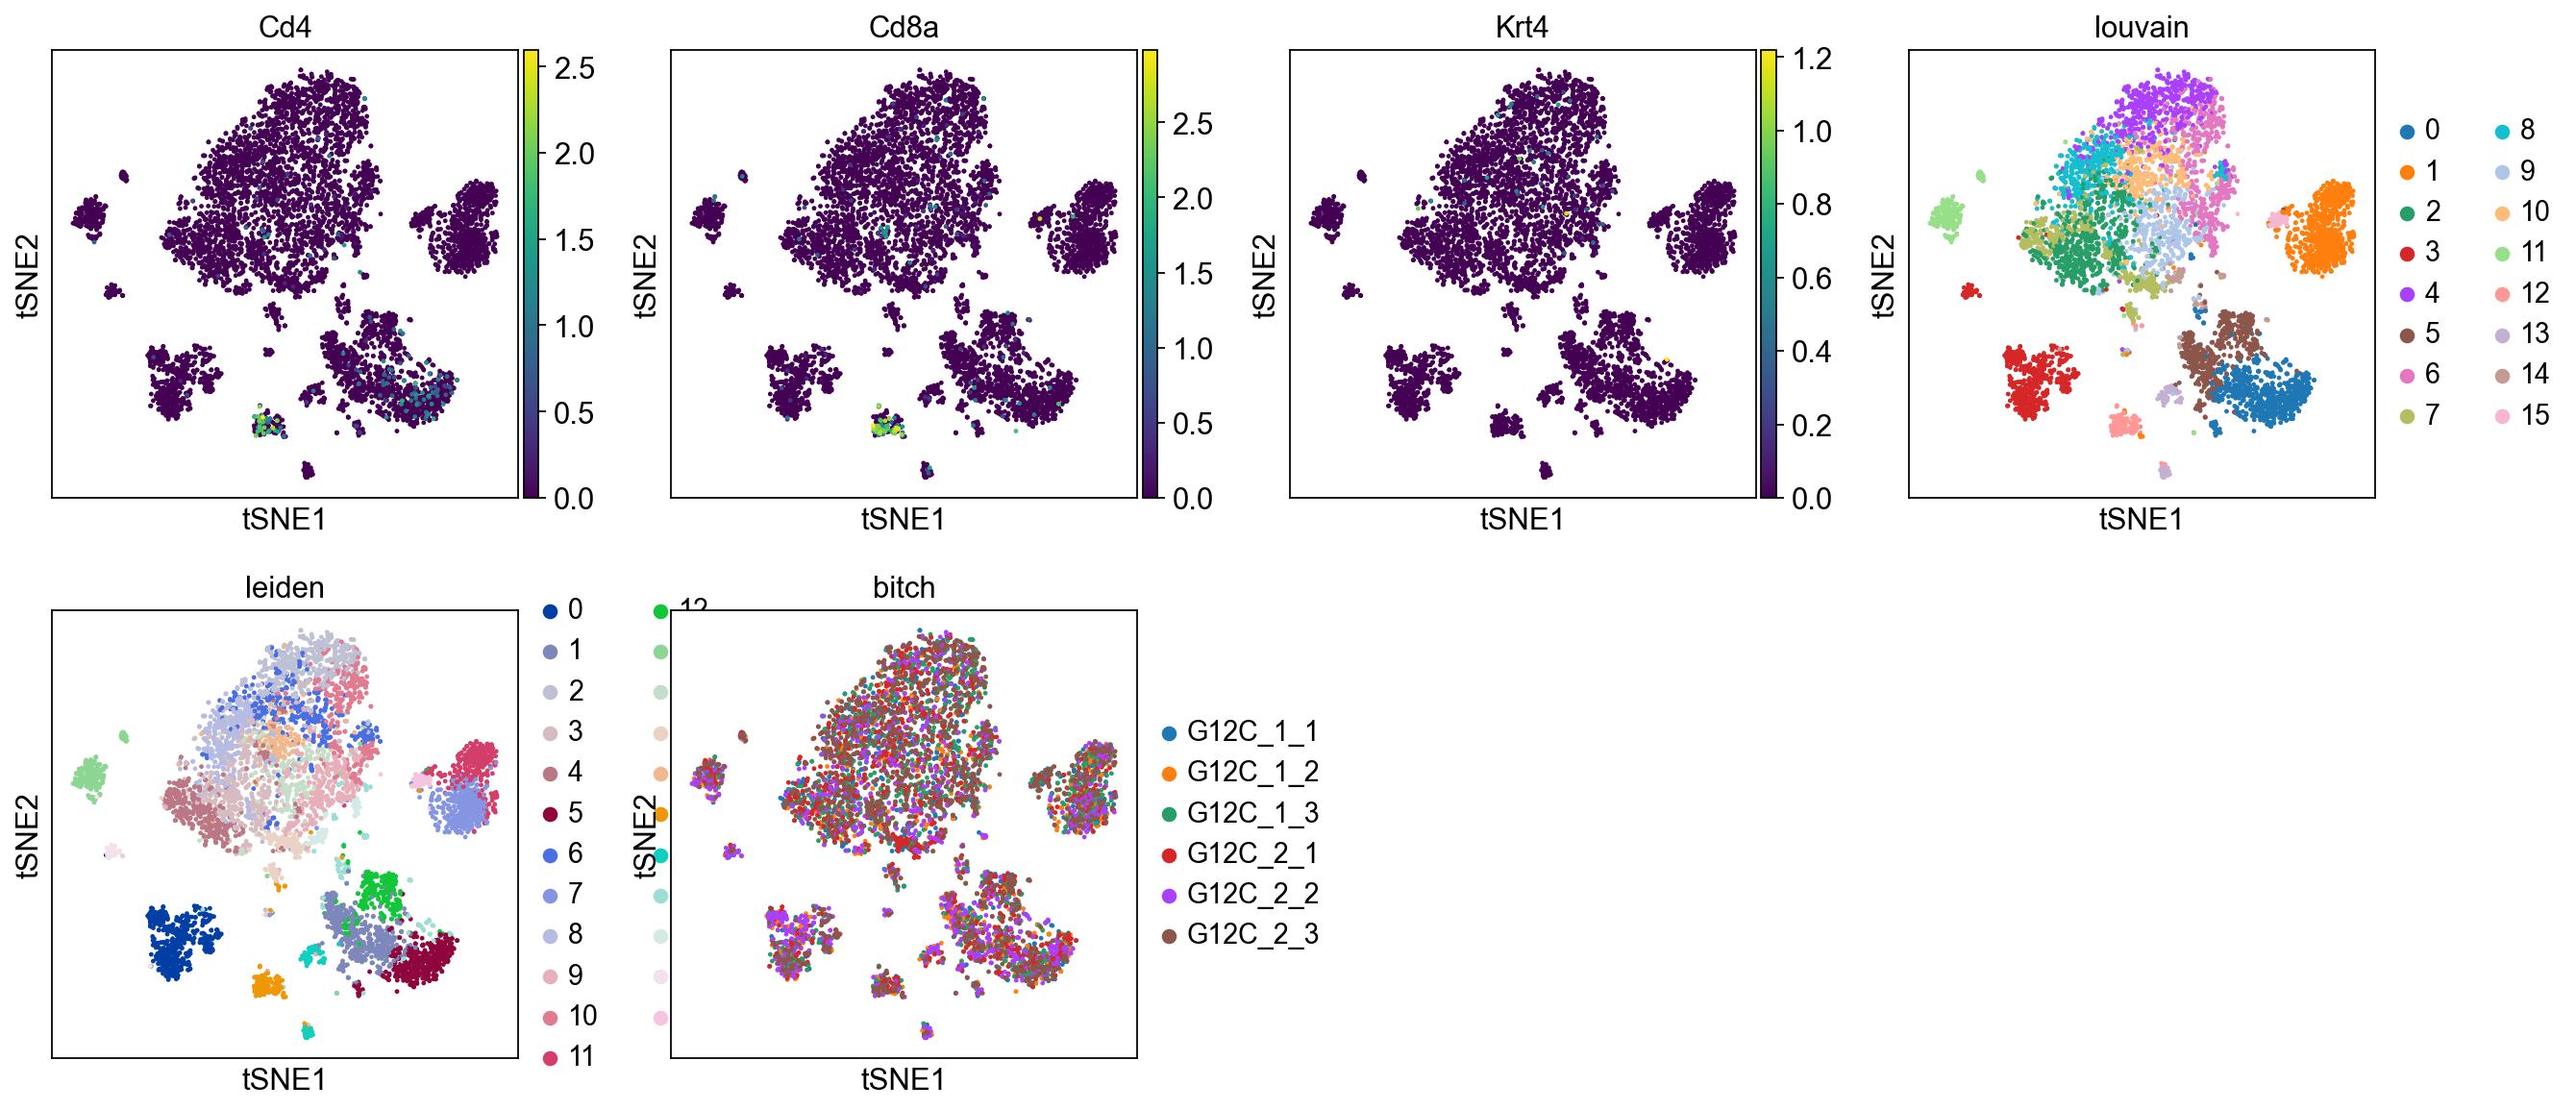

running PAGA
    finished (0:00:00)
computing UMAP
    finished (0:00:07)


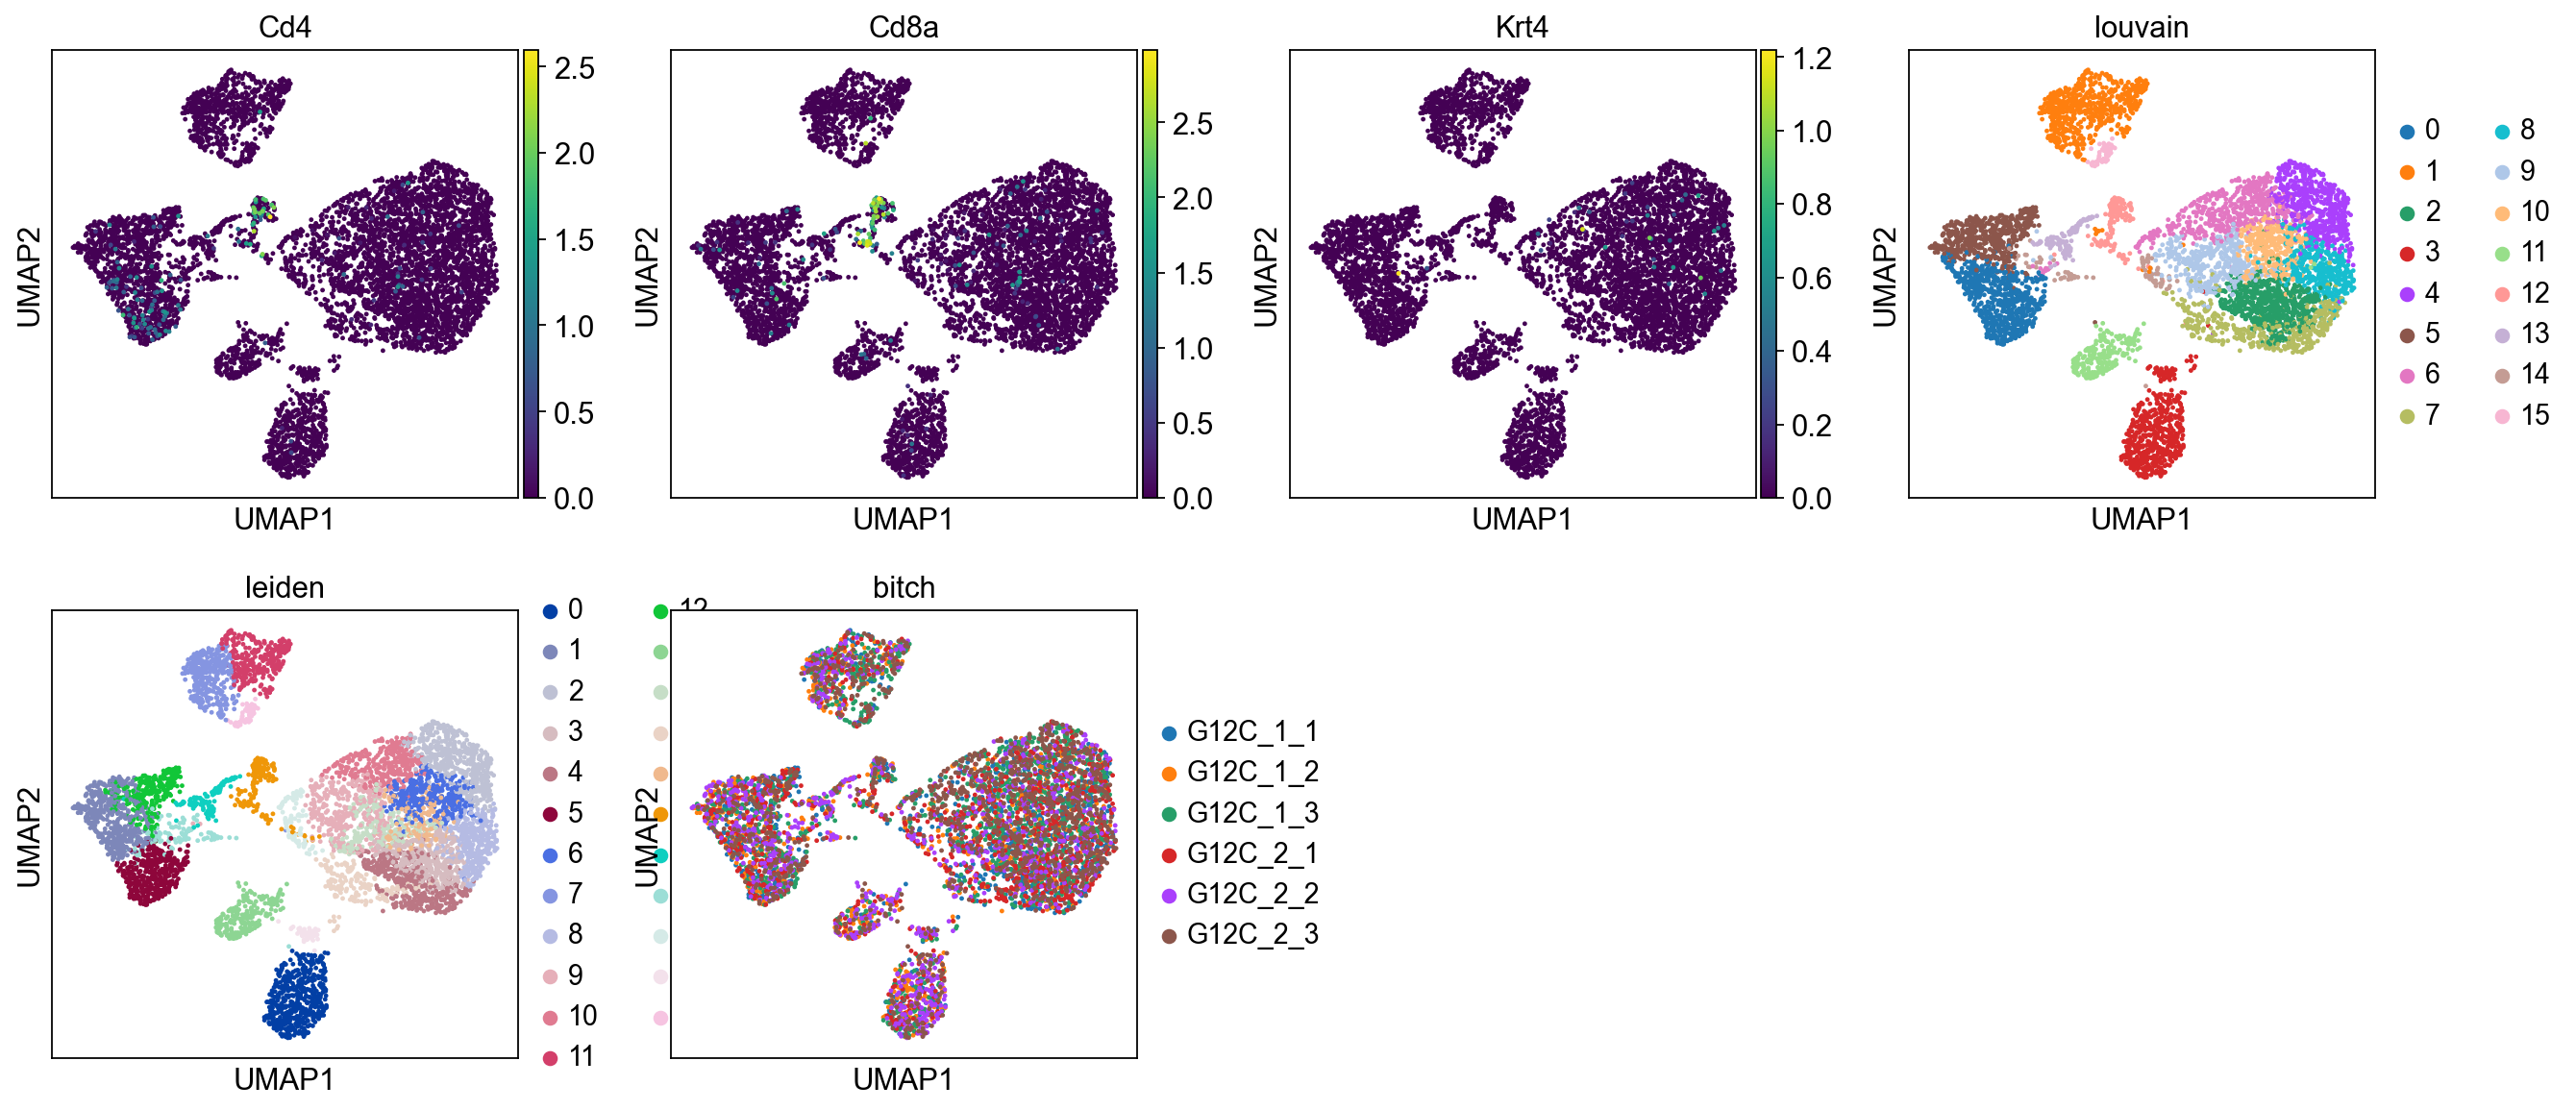

ranking genes
    finished (0:00:20)


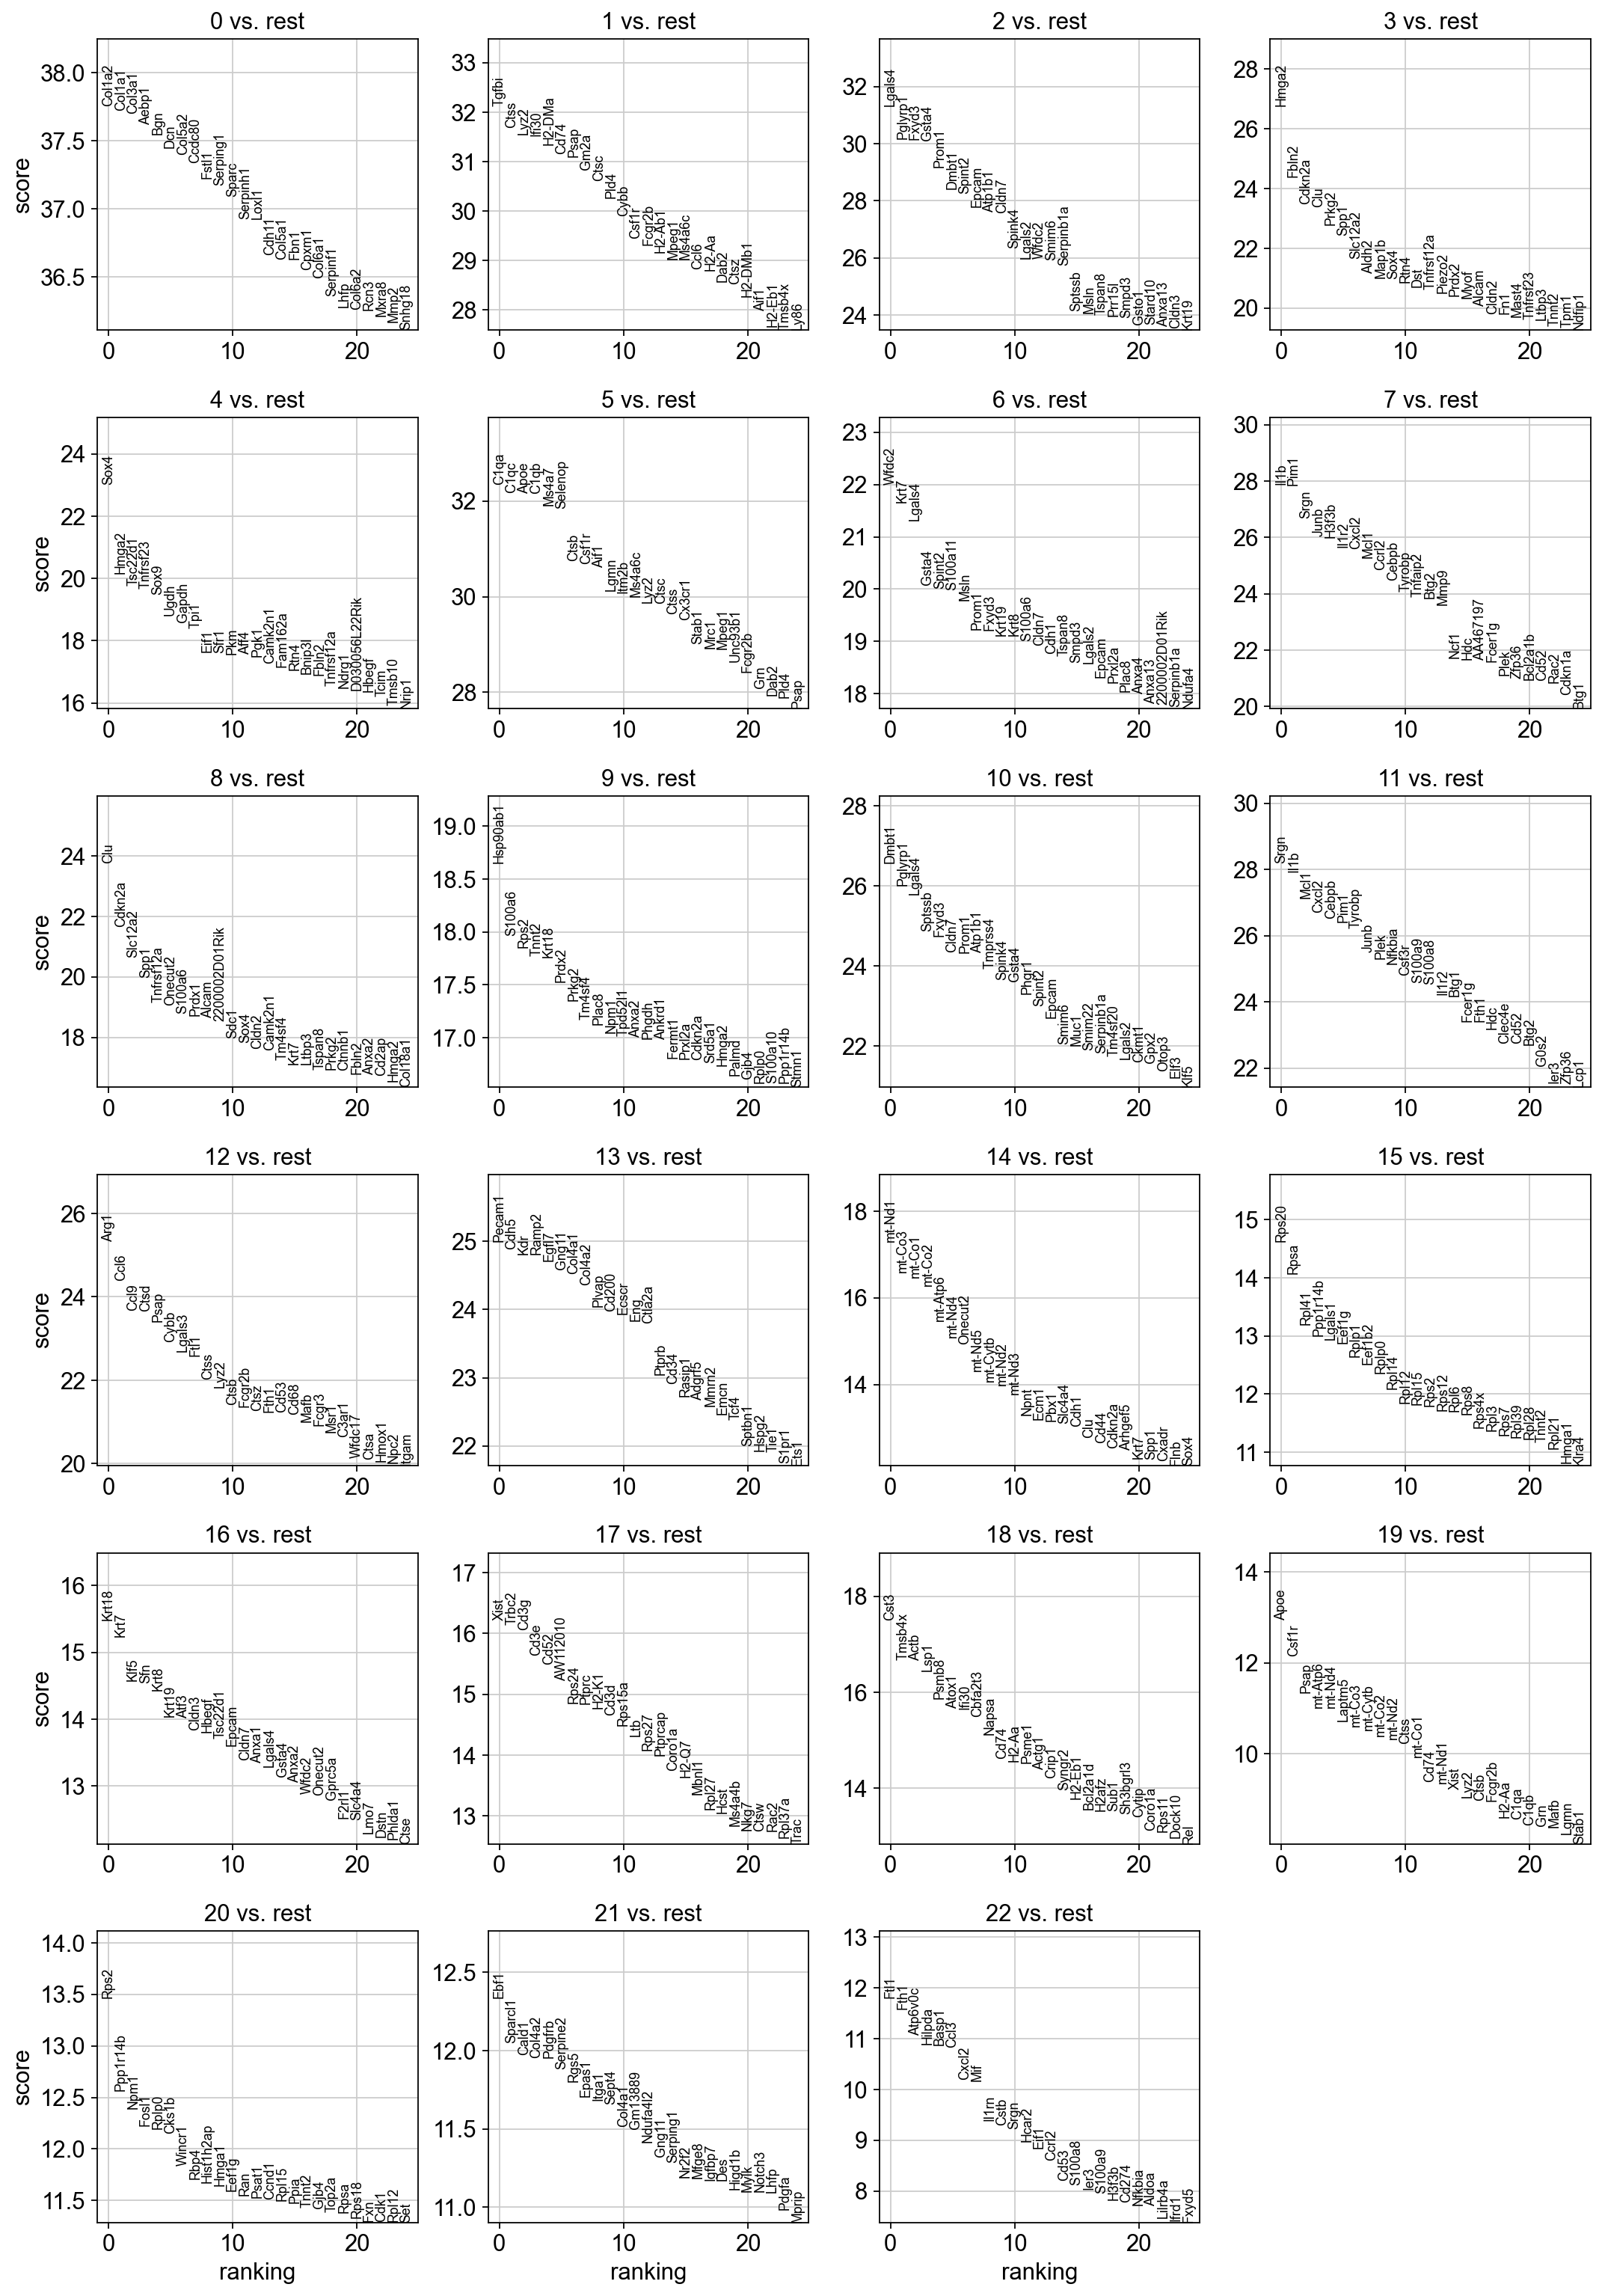

0       1          2          3          4        5        6  \
0     Col1a2   Tgfbi     Lgals4      Hmga2       Sox4     C1qa    Wfdc2   
1     Col1a1    Ctss    Pglyrp1      Fbln2      Hmga2     C1qc     Krt7   
2     Col3a1    Lyz2      Fxyd3     Cdkn2a    Tsc22d1     Apoe   Lgals4   
3      Aebp1   Ifi30      Gsta4        Clu   Tnfrsf23     C1qb    Gsta4   
4        Bgn  H2-DMa      Prom1      Prkg2       Sox9    Ms4a7   Spint2   
5        Dcn    Cd74      Dmbt1       Spp1       Ugdh  Selenop  S100a11   
6     Col5a2    Psap     Spint2    Slc12a2      Gapdh     Ctsb     Msln   
7     Ccdc80    Gm2a      Epcam      Aldh2       Tpi1    Csf1r    Prom1   
8      Fstl1    Ctsc     Atp1b1      Map1b       Eif1     Aif1    Fxyd3   
9   Serping1    Pld4      Cldn7       Sox4       Sfr1     Lgmn    Krt19   
10     Sparc    Cybb     Spink4       Rtn4        Pkm    Itm2b     Krt8   
11  Serpinh1   Csf1r     Lgals2        Dst       Aff4   Ms4a6c   S100a6   
12     Loxl1  Fcgr2b      Wfdc2  Tnfrsf12a       Pgk1     Lyz2    Cldn7   
13     Cdh11  H2-Ab1      Smim6     Piezo2    Camk2n1     Ctsc     Cdh1   
14    Col5a1   Mpeg1  Serpinb1a      Prdx2    Fam162a     Ctss   Tspan8   
15      Fbn1  Ms4a6c     Sptssb       Myof       Rtn4   Cx3cr1    Smpd3   
16     Cpxm1    Ccl6       Msln      Alcam     Bnip3l    Stab1   Lgals2   
17    Col6a1   H2-Aa     Tspan8      Cldn2      Fbln2     Mrc1    Epcam   
18  Serpinf1    Dab2     Prr15l        Fn1  Tnfrsf12a    Mpeg1   Prxl2a   
19      Lhfp    Ctsz      Smpd3      Mast4      Ndrg1  Unc93b1    Plac8   

           7              8         9         10      11      12      13  \
0       Il1b            Clu  Hsp90ab1      Dmbt1    Srgn    Arg1  Pecam1   
1       Pim1         Cdkn2a    S100a6    Pglyrp1    Il1b    Ccl6    Cdh5   
2       Srgn        Slc12a2      Rps2     Lgals4    Mcl1    Ccl9     Kdr   
3       Junb           Spp1     Tnnt2     Sptssb   Cxcl2    Ctsd   Ramp2   
4      H3f3b      Tnfrsf12a     Krt18      Fxyd3   Cebpb    Psap   Egfl7   
5      Il1r2        Onecut2     Prdx2      Cldn7    Pim1    Cybb   Gng11   
6      Cxcl2         S100a6     Prkg2      Prom1  Tyrobp  Lgals3  Col4a1   
7       Mcl1          Prdx1    Tm4sf4     Atp1b1    Junb    Ftl1  Col4a2   
8      Ccrl2          Alcam     Plac8    Tmprss4    Plek    Ctss   Plvap   
9      Cebpb  2200002D01Rik      Npm1     Spink4  Nfkbia    Lyz2   Cd200   
10    Tyrobp           Sdc1   Tpd52l1      Gsta4   Csf3r    Ctsb   Ecscr   
11   Tnfaip2           Sox4     Anxa2      Phgr1  S100a9  Fcgr2b     Eng   
12      Btg2          Cldn2     Phgdh     Spint2  S100a8    Ctsz  Ctla2a   
13      Mmp9        Camk2n1    Ankrd1      Epcam   Il1r2    Fth1   Ptprb   
14      Ncf1         Tm4sf4    Fermt1      Smim6    Btg1    Cd53    Cd34   
15       Hdc           Krt7    Prxl2a       Muc1  Fcer1g    Cd68  Rasip1   
16  AA467197          Ltbp3    Cdkn2a     Smim22    Fth1    Mafb  Adgrf5   
17    Fcer1g         Tspan8    Srd5a1  Serpinb1a     Hdc   Fcgr3   Mmrn2   
18      Plek          Prkg2     Hmga2    Tm4sf20  Clec4e    Msr1    Emcn   
19     Zfp36         Ctnnb1     Palmd     Lgals2    Cd52   C3ar1    Tcf4   

         14        15       16        17        18       19         20  \
0    mt-Nd1     Rps20    Krt18      Xist      Cst3     Apoe       Rps2   
1    mt-Co3      Rpsa     Krt7     Trbc2    Tmsb4x    Csf1r   Ppp1r14b   
2    mt-Co1     Rpl41     Klf5      Cd3g      Actb     Psap       Npm1   
3    mt-Co2  Ppp1r14b      Sfn      Cd3e      Lsp1  mt-Atp6      Fosl1   
4   mt-Atp6    Lgals1     Krt8      Cd52     Psmb8   mt-Nd4      Rplp0   
5    mt-Nd4     Eef1g    Krt19  AW112010     Atox1   Laptm5      Cks1b   
6   Onecut2     Rplp1     Atf3     Rps24     Ifi30   mt-Co3     Wincr1   
7    mt-Nd5    Eef1b2    Cldn3     Ptprc   Cbfa2t3  mt-Cytb       Rbp4   
8   mt-Cytb     Rplp0    Hbegf     H2-K1     Napsa   mt-Co2  Hist1h2ap   
9    mt-Nd2     Rpl14  Tsc22d1      Cd3d      Cd74   mt-Nd2      Hmga1   
10   mt-Nd3     Rpl12   

In [232]:
results_map = {}
cond = 'G12C'

print(f'Running {cond}\n----------------------------------------------------------------------------\n')
adata = read_data(cond, replicate_num=None)
adata = mt_initial_preprocess_and_plot(adata)
adata = preprocess(adata, min_mean=0.3, min_disp=0.3)
adata = neighborhood_graph_and_clustering(adata, color=['Cd4', 'Cd8a', 'Krt4', 'louvain', 'leiden','bitch'], 
                                          n_pcs=10, use_raw=True, perplexity=30)
adata, top_genes_df = markers(adata)

display(top_genes_df)

results_map[cond] = {}
results_map[cond]['adata'] = adata
results_map[cond]['top_genes_df'] = top_genes_df



In [ ]:
results_map = {}
conditions = ['G12C', 'G12D', 'G12R']

for cond in conditions:
    print(f'Running {cond}\n----------------------------------------------------------------------------\n')
    adata = read_data(cond, replicate_num=None)
    adata = mt_initial_preprocess_and_plot(adata)
    adata = preprocess(adata, min_mean=0.3, min_disp=0.3)
    adata = neighborhood_graph_and_clustering(adata, color=['Cd4', 'Cd8a', 'Krt4', 'louvain', 'leiden'], 
                                              n_pcs=5, use_raw=True, perplexity=30)
    adata, top_genes_df = markers(adata)
    
    display(top_genes_df)
    
    results_map[cond] = {}
    results_map[cond]['adata'] = adata
    results_map[cond]['top_genes_df'] = top_genes_df
    
    break